# Tests on the PDF module

The core of this package is the KDE-based PDF in multi-dimensional space. Here we provide some examples of the PDF module. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from StarStream import KernelPDF

## Generate some sample points from a known PDF, e.g., Gaussian tube around a sin function

$$
p(x,y) = \frac{1}{\sqrt{2\pi\sigma^2}}\exp\left[-\frac{(y-\sin x)^2}{2\sigma^2}\right]
$$

In [2]:
def real_pdf(x, y, sig):
    return np.exp(-0.5*(y-np.sin(x))**2/sig**2) / np.sqrt(2*np.pi) / sig

# sample: 

Nsamp = 3000
sig = 0.4
seed = 42
xrange = (0.0, 10.0)
yrange = (-3.0, 3.0)
rng = np.random.default_rng(seed)
x = rng.uniform(low=xrange[0], high=xrange[1], size=Nsamp)
y = np.sin(x) + rng.normal(loc=0.0, scale=sig, size=Nsamp)

In [3]:
norm = 1 / (xrange[1] - xrange[0])

pbase = norm*real_pdf(0.0, 0.0, sig)
p1sig = pbase * np.exp(-0.5)
p2sig = pbase * np.exp(-2.0)
p3sig = pbase * np.exp(-4.5)

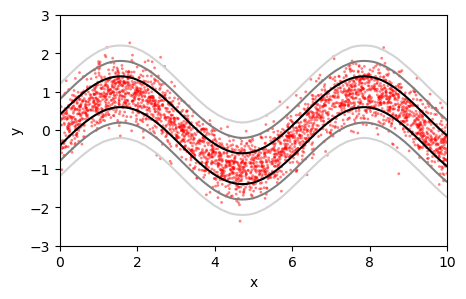

In [4]:
dx, dy = 0.1, 0.1
xgrid, ygrid = np.arange(xrange[0],xrange[1]+0.01,dx), np.arange(yrange[0],yrange[1]+0.01,dy)
xx, yy = np.meshgrid(xgrid, ygrid)

xx_flat, yy_flat = xx.flatten(), yy.flatten()
zz_flat = norm*real_pdf(xx_flat, yy_flat, sig)
zz = zz_flat.reshape(xx.shape)

fig, ax0 = plt.subplots(1, 1, figsize=(5,3))

ax0.contour(xx, yy, zz, levels=[p3sig, p2sig, p1sig], colors=["lightgray", "gray", "k"])

ax0.scatter(x,y, s=4, alpha=0.5, fc="r", ec="None")

ax0.set_xlabel("x")
ax0.set_ylabel("y")
ax0.set_xlim(*xrange)
ax0.set_ylim(*yrange)

plt.show()

## Now, estimate PDF using KernelPDF

### First, direct KDE

This is more computationally expensive, but can take error.

In [5]:
data = np.c_[x, y]
grids = [None, None] # None means no interpolation, just direct KDE
hs = np.c_[
    np.full_like(x, fill_value=0.2),
    np.full_like(x, fill_value=0.2),
]

pdf = KernelPDF(data, grids, hs, [[0, 1]])

data_est = np.c_[xx_flat, yy_flat]
%timeit pdf.eval_pdf(data_est)
zz_est_flat = pdf.eval_pdf(data_est)
zz_est = zz_est_flat.reshape(xx.shape)

1.63 s ± 182 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [6]:
np.repeat([[1,2]], 3, axis=0)

array([[1, 2],
       [1, 2],
       [1, 2]])

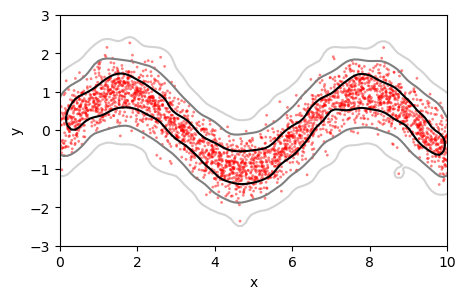

In [7]:
fig, ax0 = plt.subplots(1, 1, figsize=(5,3))

ax0.contour(xx, yy, zz_est, levels=[p3sig, p2sig, p1sig], colors=["lightgray", "gray", "k"])

ax0.scatter(x,y, s=4, alpha=0.5, fc="r", ec="None")

ax0.set_xlabel("x")
ax0.set_ylabel("y")
ax0.set_xlim(*xrange)
ax0.set_ylim(*yrange)

plt.show()

In [8]:
# Verify that the integral is 1 

print(f"The integral of the PDF is {np.sum(zz_est*dx*dy): .3f}")

The integral of the PDF is  0.988


### We can also try adding error to points

In [9]:
err = np.full_like(data_est, fill_value=0.4)

zz_est_with_err_flat = pdf.eval_pdf(data_est, err)
zz_est_with_err = zz_est_with_err_flat.reshape(xx.shape)

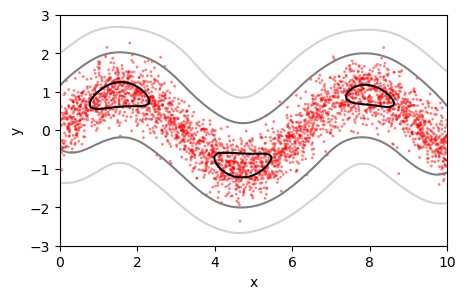

In [10]:
fig, ax0 = plt.subplots(1, 1, figsize=(5,3))

ax0.contour(xx, yy, zz_est_with_err, levels=[p3sig, p2sig, p1sig], colors=["lightgray", "gray", "k"])

ax0.scatter(x,y, s=4, alpha=0.5, fc="r", ec="None")

ax0.set_xlabel("x")
ax0.set_ylabel("y")
ax0.set_xlim(*xrange)
ax0.set_ylim(*yrange)

plt.show()

So, adding errors effectively makes the PDF more diffuse.

### Just for fun, let's check how the PDF looks like if we do KDE seperately in each dimension

In [11]:
pdf_sep = KernelPDF(data, grids, hs, [[0], [1]]) # KDE seperately in 1D

zz_est_sep_flat = pdf_sep.eval_pdf(data_est)
zz_est_sep = zz_est_sep_flat.reshape(xx.shape)

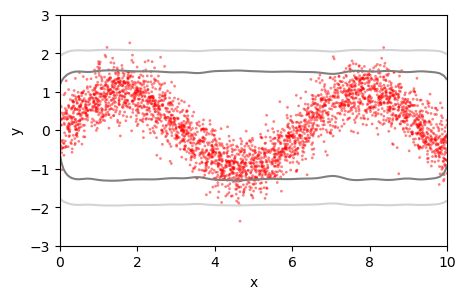

In [12]:
fig, ax0 = plt.subplots(1, 1, figsize=(5,3))

ax0.contour(xx, yy, zz_est_sep, levels=[p3sig, p2sig, p1sig], colors=["lightgray", "gray", "k"])

ax0.scatter(x,y, s=4, alpha=0.5, fc="r", ec="None")

ax0.set_xlabel("x")
ax0.set_ylabel("y")
ax0.set_xlim(*xrange)
ax0.set_ylim(*yrange)

plt.show()

The contours look like rectangles, with no correlation between x and y

### Second, grid interpolation

This is more computationally efficient, but takes no error.

In [13]:
data = np.c_[x, y]
grids = [xgrid, ygrid] # All you need is to set grids to not None, then interpolation turns on automatically
hs = np.c_[
    np.full_like(x, fill_value=0.2),
    np.full_like(x, fill_value=0.2),
]

pdf_grid = KernelPDF(data, grids, hs, [[0, 1]])

%timeit pdf_grid.eval_pdf(data_est)
zz_est_grid_flat = pdf_grid.eval_pdf(data_est)
zz_est_grid = zz_est_grid_flat.reshape(xx.shape)

346 µs ± 44.7 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


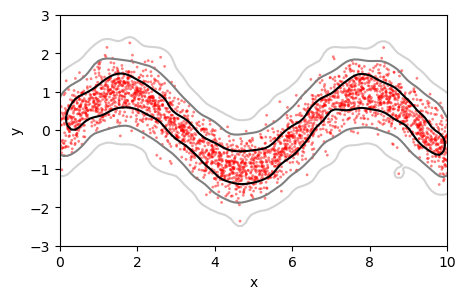

In [14]:
fig, ax0 = plt.subplots(1, 1, figsize=(5,3))

ax0.contour(xx, yy, zz_est_grid, levels=[p3sig, p2sig, p1sig], colors=["lightgray", "gray", "k"])

ax0.scatter(x,y, s=4, alpha=0.5, fc="r", ec="None")

ax0.set_xlabel("x")
ax0.set_ylabel("y")
ax0.set_xlim(*xrange)
ax0.set_ylim(*yrange)

plt.show()

This looks identical to direct KDE, since our interpolation grid is the same as the plotting grid.